<a href="https://colab.research.google.com/github/parikshithrao/ML/blob/master/fake_or_real_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+4" color=teal><u><center>Fake News Classifier </center></u></font>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of contents</h3>

* [Introduction](#intro)
* [Data cleaning and Feature extraction](#data)
* [1.  Title - Word Clouds ](#1)
* [2.  Length - Title/Text ](#2)
* [3.  Ngrams - Title words](#3)
* [4.  Removal of stopwords](#4)
* [5.  Count Vectorizer](#5)
* [6.  Passive Aggressive Classifier Classifier for CountVectorizer](#6)
* [7.  Hyper Paramterization with Multinomial NB for CountVectorizer](#7)
* [8.  TfidfVectorizer](#8)	
* [9.  Hyperparameterization (with MultinomialNB) for TfidfVectorizer](#11)
* [11. PassiveAggressiveClassifier for TfidfVectorizer](#12)
* [12. Hashing Vectorizer](#13)
* [13. Comparison Table](#14)
* [14. LSTM](#15)
    


<a id="intro"></a>
<font size="+2" color="blue"><b>Introduction and Imports</b></font><br>

<font size="+1" color="magenta">
There are 2 files one which has true news and the other fake news.
</font>

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset_internship'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import re
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import spacy
tf.__version__


/content/drive/MyDrive/dataset_internship/Fake.csv
/content/drive/MyDrive/dataset_internship/True.csv


'2.8.2'

In [21]:
fake = pd.read_csv("/content/drive/MyDrive/dataset_internship/Fake.csv", parse_dates=['date'])
true = pd.read_csv("/content/drive/MyDrive/dataset_internship/True.csv", parse_dates=['date'])

<a id="data"></a>
<font size="+2" color="blue"><b>Cleaning data</b></font><br>

In [22]:
print(fake.info())
print(fake.head())
print(fake['subject'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Tr

In [23]:
fake[fake['date']=="https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/"]
fake.loc[9358]['date'] = 'December 31, 2017'


fake[fake['date']=="https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/"]
fake.loc[15507]['date'] = 'December 29, 2017'

fake[fake['date']=="https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/"]
fake.loc[15508]['date'] = 'December 30, 2017'

 
fake[fake['date']=="https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg"]
fake.loc[15839]['date'] = 'December 30, 2017'
fake.loc[17432]['date'] = 'December 26, 2017'
fake.loc[21869]['date'] = 'December 25, 2017'

 
fake[fake['date']=="https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg"]
fake.loc[15840]['date'] = 'December 29, 2017'
fake.loc[17433]['date'] = 'December 28, 2017'
fake.loc[21870]['date'] = 'December 27, 2017'

fake[fake['date']=="MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]"]
fake.loc[18933]['date'] = 'December 24, 2017'
fake['date'] = pd.to_datetime(fake['date'], dayfirst = True)
print("Fake News dates: ",fake['date'].min(), fake['date'].max())
print("True News dates: ",true['date'].min(), true['date'].max())

Fake News dates:  2015-03-31 00:00:00 2018-02-19 00:00:00
True News dates:  2016-01-13 00:00:00 2017-12-31 00:00:00


In [24]:
print(true.info())
print(true.head())
print(true['subject'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 669.4+ KB
None
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject       date  
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews 2017-12-31  
1  WASHINGTON (Reuters) - Transgender people will...  polit

In [25]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# Data cleaning
def remove_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def remove_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def remove_hash(text):
    line=re.sub(r'#\w+','',text)
    return line
def remove_newline(string):
    text=re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def remove_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def text_strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line   

In [26]:
fake['refine_text']=fake['text'].str.lower()
fake['refine_text']=fake['refine_text'].apply(lambda x:remove_tag(str(x)))
fake['refine_text']=fake['refine_text'].apply(lambda x:remove_mention(str(x)))
fake['refine_text']=fake['refine_text'].apply(lambda x:remove_hash(str(x)))
fake['refine_text']=fake['refine_text'].apply(lambda x:remove_newline(x))
fake['refine_text']=fake['refine_text'].apply(lambda x:remove_url(x))
fake['refine_text']=fake['refine_text'].apply(lambda x:remove_number(x))
fake['refine_text']=fake['refine_text'].apply(lambda x:remove_punct(x))
fake['refine_text']=fake['refine_text'].apply(lambda x:text_strip(x))
fake['text_length']=fake['refine_text'].str.split().map(lambda x: len(x))

true['refine_text']=true['text'].str.lower()
true['refine_text']=true['refine_text'].apply(lambda x:remove_tag(str(x)))
true['refine_text']=true['refine_text'].apply(lambda x:remove_mention(str(x)))
true['refine_text']=true['refine_text'].apply(lambda x:remove_hash(str(x)))
true['refine_text']=true['refine_text'].apply(lambda x:remove_newline(x))
true['refine_text']=true['refine_text'].apply(lambda x:remove_url(x))
true['refine_text']=true['refine_text'].apply(lambda x:remove_number(x))
true['refine_text']=true['refine_text'].apply(lambda x:remove_punct(x))
true['refine_text']=true['refine_text'].apply(lambda x:text_strip(x))
true['text_length']=true['refine_text'].str.split().map(lambda x: len(x))

fake['refine_title']=fake['title'].str.lower()
fake['refine_title']=fake['refine_title'].apply(lambda x:remove_tag(str(x)))
fake['refine_title']=fake['refine_title'].apply(lambda x:remove_mention(str(x)))
fake['refine_title']=fake['refine_title'].apply(lambda x:remove_hash(str(x)))
fake['refine_title']=fake['refine_title'].apply(lambda x:remove_newline(x))
fake['refine_title']=fake['refine_title'].apply(lambda x:remove_url(x))
fake['refine_title']=fake['refine_title'].apply(lambda x:remove_number(x))
fake['refine_title']=fake['refine_title'].apply(lambda x:remove_punct(x))
fake['refine_title']=fake['refine_title'].apply(lambda x:text_strip(x))
fake['title_length']=fake['refine_title'].str.split().map(lambda x: len(x))

true['refine_title']=true['title'].str.lower()
true['refine_title']=true['refine_title'].apply(lambda x:remove_tag(str(x)))
true['refine_title']=true['refine_title'].apply(lambda x:remove_mention(str(x)))
true['refine_title']=true['refine_title'].apply(lambda x:remove_hash(str(x)))
true['refine_title']=true['refine_title'].apply(lambda x:remove_newline(x))
true['refine_title']=true['refine_title'].apply(lambda x:remove_url(x))
true['refine_title']=true['refine_title'].apply(lambda x:remove_number(x))
true['refine_title']=true['refine_title'].apply(lambda x:remove_punct(x))
true['refine_title']=true['refine_title'].apply(lambda x:text_strip(x))
true['title_length']=true['refine_title'].str.split().map(lambda x: len(x))

<a id="1"></a>
<font size="+2" color="blue"><b>Title Word Clouds</b></font><br>

Text(0.5, 1.0, 'Fake News - Most Used Words in Title')

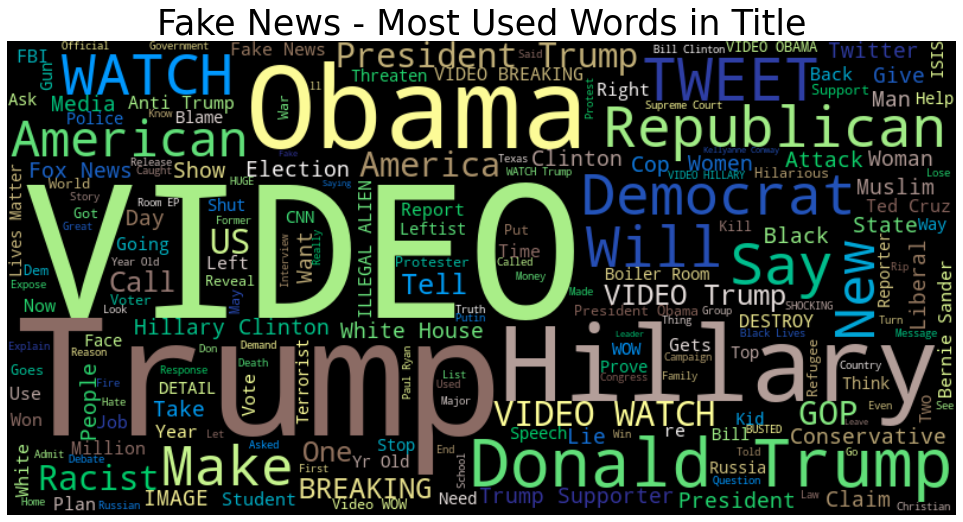

In [27]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='black',colormap="terrain_r",width=800,height=400).generate(" ".join(fake['title']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Fake News - Most Used Words in Title',fontsize=35)

Text(0.5, 1.0, 'True News - Most Used Words in Title')

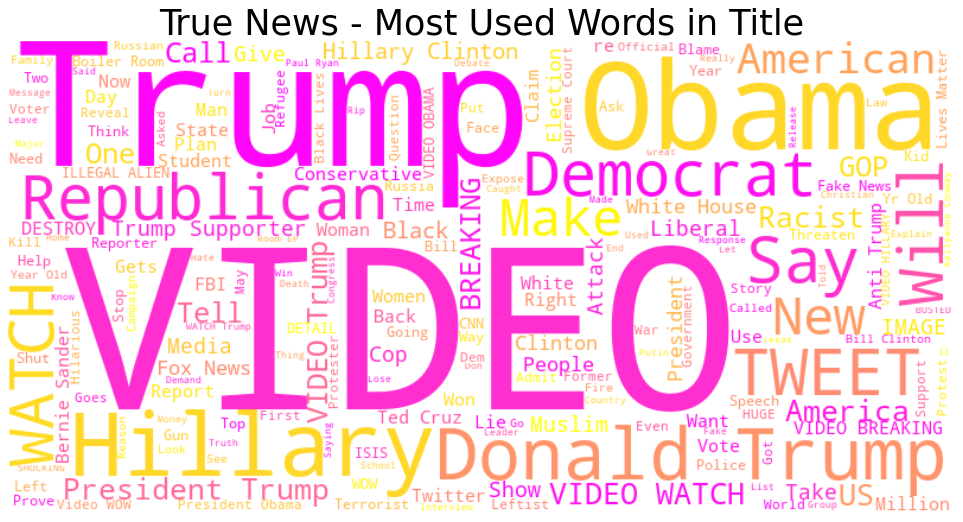

In [28]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='white',colormap="spring", width=800,height=400).generate(" ".join(fake['title']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('True News - Most Used Words in Title',fontsize=35)

In [29]:
print("Average length of True News  : {}".format(round(true['text_length'].mean(),2)))
print("Average length of Fake News  : {}".format(round(fake['text_length'].mean(),2)))
print("Average title length of True News  : {}".format(round(true['title_length'].mean(),2)))
print("Average title length of Fake News  : {}".format(round(fake['title_length'].mean(),2)))

Average length of True News  : 379.12
Average length of Fake News  : 416.82
Average title length of True News  : 9.85
Average title length of Fake News  : 14.59


<a id="2"></a>
<font size="+2" color="blue"><b>Title/Text Length of True/Fake news</b></font><br>

In [30]:
fig = go.Figure()

fig.add_trace(go.Violin(y=true['title_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='magenta', opacity=0.6,name="True", x0='True News'))
fig.add_trace(go.Violin(y=fake['title_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='skyblue', opacity=0.6,name="Fake", x0='Fake News') )

fig.update_traces(box_visible=False, meanline_visible=True)
fig.update_layout(title_text="Violin - News Title Length",title_x=0.5)
fig.show()

In [31]:
fig = go.Figure()

fig.add_trace(go.Violin(y=true['text_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='green', opacity=0.6,name="True", x0='True News'))
fig.add_trace(go.Violin(y=fake['text_length'], box_visible=False, line_color='black', meanline_visible=True, fillcolor='red', opacity=0.6,name="Fake", x0='Fake News') )

fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_layout(title_text="Violin - News Length",title_x=0.5)
fig.show()

<a id="3"></a>
<font size="+2" color="blue"><b>Ngrams of True/Fake news titles</b></font><br>

In [32]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df
unigram_df=ngram_df(true['refine_title'],(1,1),20)
bigram_df=ngram_df(true['refine_title'],(2,2),20)
trigram_df=ngram_df(true['refine_title'],(3,3),20)

unigram_fake_df=ngram_df(fake['refine_title'],(1,1),20)
bigram_fake_df=ngram_df(fake['refine_title'],(2,2),20)
trigram_fake_df=ngram_df(fake['refine_title'],(3,3),20)

In [33]:
fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top True News N Grams',xaxis_title=" ",yaxis_title=" ", showlegend=False,title_x=0.5,height=1200,template="plotly_white")
fig.show()

In [34]:
fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_fake_df['text'][::-1],
    x=unigram_fake_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_fake_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_fake_df['text'][::-1],
    x=bigram_fake_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_fake_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_fake_df['text'][::-1],
    x=trigram_fake_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_fake_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top Fake titles N Grams',xaxis_title=" ",yaxis_title=" ", showlegend=False,title_x=0.5,height=1200,template="seaborn")
fig.show()

In [35]:
true['label'] = 1
fake['label'] = 0
news = pd.concat([true,fake],ignore_index=True)
y = news['label']
news = news.drop(['label'],axis = 1)
news


,title,text,subject,date,refine_text,text_length,refine_title,title_length
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,washington reuters the head of a conservative ...,730,as us budget fight looms republicans flip thei...,10
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,washington reuters transgender people will be ...,612,us military to accept transgender recruits on ...,9
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,washington reuters the special counsel investi...,454,senior us republican senator let mr mueller do...,10
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,washington reuters trump campaign adviser geor...,372,fbi russia probe helped by australian diplomat...,9
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,seattlewashington reuters president donald tru...,827,trump wants postal service to charge much more...,11
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,st century wire says as wire reported earlier ...,519,mcpain john mccain furious that iran treated u...,10
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,st century wire says it s a familiar theme whe...,294,justice yahoo settles email privacy classactio...,11
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,patrick henningsen st century wireremember whe...,4136,sunnistan us and allied ‘safe zone’ plan to ta...,14
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,st century wire says al jazeera america will g...,443,how to blow million al jazeera america finally...,11


<a id="4"></a>
<font size="+2" color="blue"><b>Removal of Stopwords</b> </font><br>

In [40]:
nlp = spacy.load("en_core_web_sm")
def lem_stp(df,column):

    for doc in nlp.pipe(df[column], disable=["parser", "ner"], batch_size=512):
        yield " ".join(
            [d.text for d in doc if not d.is_stop]
        )

corpus = list(lem_stp(news,'refine_text'))
# corpus = news['refine_text']

In [41]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<a id="5"></a>
<font size="+2" color="blue"><b>Count Vectorizer</b> </font><br>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Feature Names:  ['about', 'about the', 'according', 'according to', 'act', 'actually', 'added', 'administration', 'after', 'after the', 'again', 'against', 'agency', 'all', 'already', 'also', 'america', 'american', 'americans', 'among']
X shape:  (44898, 500)
Get Params:  {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': 500, 'min_df': 1, 'ngram_range': (1, 3), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
X_train.shape, X_test.shape, y_train.shape, y_test.shape:  (30081, 500) (14817, 500) (30081,) (14817,)
Score:  0.9386515488965378
Confusion matrix, without normalization


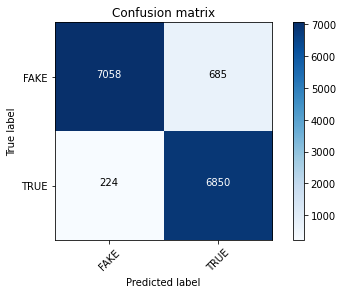

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import itertools

cv = CountVectorizer(max_features = 500, ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
feature_names = cv.get_feature_names()
print("Feature Names: ",feature_names[:20])
print("X shape: ",X.shape)
print("Get Params: ",cv.get_params())

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.33, random_state=10)
print("X_train.shape, X_test.shape, y_train.shape, y_test.shape: ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

classifier = MultinomialNB()
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print("Score: ",score)

cm = metrics.confusion_matrix(y_test,pred)
plot_confusion_matrix(cm, classes = ['FAKE', 'TRUE'])

<a id="7"></a>
<font size="+2" color="blue"><b>Hyper Parameterization (MultinomialNB) for CountVectorizer </b> </font><br>

In [43]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["S No.", "Alpha Value", "Score"]

previous_score = 0
i=1

# Hyperparameters with MultinomialNB
for alpha in np.arange(0,1,0.1):
    sclf = MultinomialNB(alpha = alpha)
    sclf.fit(X_train,y_train)
    pred = sclf.predict(X_test)
    score = metrics.accuracy_score(pred,y_test)
    if score > previous_score:
        clf = sclf
    #print("Alpha: {}, Score: {} ".format(alpha, score))
    pt.add_row([i,round(alpha,1),round(score,3)])
    i = i+1
    
print(pt)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



+-------+-------------+-------+
| S No. | Alpha Value | Score |
+-------+-------------+-------+
|   1   |     0.0     | 0.939 |
|   2   |     0.1     | 0.939 |
|   3   |     0.2     | 0.939 |
|   4   |     0.3     | 0.939 |
|   5   |     0.4     | 0.939 |
|   6   |     0.5     | 0.939 |
|   7   |     0.6     | 0.939 |
|   8   |     0.7     | 0.939 |
|   9   |     0.8     | 0.939 |
|   10  |     0.9     | 0.939 |
+-------+-------------+-------+


In [44]:
# Most True
sorted(zip(clf.coef_[0], feature_names),reverse=True)[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning:

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).



[(-2.3961316939008395, 'the'),
 (-3.0724814723162446, 'to'),
 (-3.2534036500918138, 'of'),
 (-3.372702279671975, 'and'),
 (-3.3784059576298464, 'in'),
 (-3.888210244820044, 'on'),
 (-3.9809497480794445, 'said'),
 (-4.098456642149335, 'that'),
 (-4.201239417149141, 'for'),
 (-4.558192947440588, 'is'),
 (-4.5823254322109115, 'with'),
 (-4.585120090425406, 'he'),
 (-4.593718906744229, 'trump'),
 (-4.6744468048609935, 'it'),
 (-4.710632792065136, 'was'),
 (-4.710821294071669, 'of the'),
 (-4.712236192875208, 'by'),
 (-4.720894830186703, 'as'),
 (-4.73937745398883, 'has'),
 (-4.841829259388376, 'in the')]

In [45]:
# Most Fake
sorted(zip(clf.coef_[0], feature_names),reverse=False)[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning:

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).



[(-15.184248932865577, 'image via'),
 (-9.5986662473621, 'image'),
 (-9.253183338594745, 'via'),
 (-9.14690851693466, 'actually'),
 (-8.956614929988355, 'didn'),
 (-8.829106243777904, 'fact'),
 (-8.800554627905013, 'doesn'),
 (-8.692177462185935, 'thing'),
 (-8.647718378836903, 'video'),
 (-8.630157263428341, 'fox'),
 (-8.5437922946086, 'story'),
 (-8.542341757655688, 'went'),
 (-8.529380746724666, 'got'),
 (-8.490099500717161, 'your'),
 (-8.422290435995022, 'why'),
 (-8.408248847106705, 'let'),
 (-8.403191306929397, 'trump is'),
 (-8.399414867395947, 'black'),
 (-8.389413533873835, 'really'),
 (-8.303636488038707, 'things')]

<a id="6"></a>
<font size="+2" color="blue"><b>Passive Aggressive Classifier for CountVectorizer</b> </font><br>

Score:  0.9931160153877303
Confusion matrix, without normalization


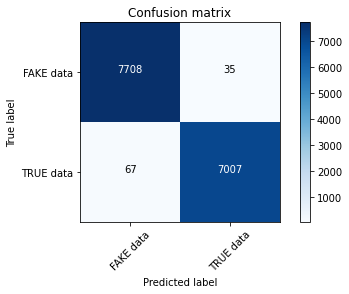

In [46]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier()

linear_clf.fit(X_train,y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print("Score: ",score)
cm = metrics.confusion_matrix(y_test,pred)
plot_confusion_matrix(cm, classes = ['FAKE data', 'TRUE data'])

<a id="8"></a>
<font size="+2" color="blue"><b>TfidfVectorizer</b> </font><br>

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create the transform
tfidf = TfidfVectorizer(max_features=500,ngram_range=(1,3))

# encode document
X = tfidf.fit_transform(corpus)

## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['about', 'about the', 'according', 'according to', 'act', 'actually', 'added', 'administration', 'after', 'after the', 'again', 'against', 'agency', 'all', 'already', 'also', 'america', 'american', 'americans', 'among']
accuracy:   0.933
Confusion matrix, without normalization


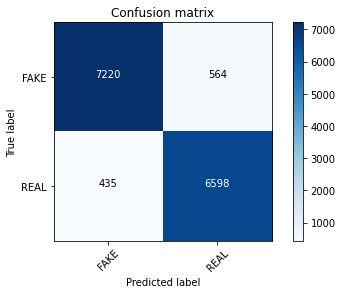

In [48]:
print(tfidf.get_feature_names()[:20])
tfidf.get_params()

clf_tf = MultinomialNB()
clf_tf.fit(X_train, y_train)
pred_tf = clf_tf.predict(X_test)
score_tf = metrics.accuracy_score(y_test, pred_tf)
print("accuracy:   %0.3f" % score_tf)
cm = metrics.confusion_matrix(y_test, pred_tf)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [49]:
# Most True
feature_names_tf = tfidf.get_feature_names()
sorted(zip(clf_tf.coef_[0], feature_names_tf),reverse=True)[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning:

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).



[(-3.0256286506583887, 'the'),
 (-3.6921196002713126, 'to'),
 (-3.856641315310762, 'of'),
 (-3.9476722317989106, 'in'),
 (-3.986227321207422, 'and'),
 (-4.281115894758688, 'said'),
 (-4.341794252755786, 'on'),
 (-4.629968916739017, 'that'),
 (-4.712012211992431, 'for'),
 (-4.776788466731931, 'trump'),
 (-4.92707195796589, 'us'),
 (-4.927622649500744, 'he'),
 (-4.9682184062764305, 'reuters'),
 (-5.0203729026966455, 'with'),
 (-5.043693388099951, 'was'),
 (-5.052744577606296, 'is'),
 (-5.078665585466399, 'by'),
 (-5.099439194701698, 'as'),
 (-5.107665003839392, 'has'),
 (-5.109128283365943, 'it')]

In [50]:
# Most Fake
feature_names_tf = tfidf.get_feature_names()
sorted(zip(clf_tf.coef_[0], feature_names_tf),reverse=False)[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning:

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).



[(-11.593443333649661, 'image via'),
 (-9.401526007198285, 'image'),
 (-8.88647775408776, 'via'),
 (-8.651700159610506, 'actually'),
 (-8.60127138665641, 'didn'),
 (-8.424875968847733, 'fact'),
 (-8.318646936343855, 'doesn'),
 (-8.284377094116973, 'thing'),
 (-8.156790943317699, 'video'),
 (-8.090344001492436, 'got'),
 (-8.074421100522933, 'really'),
 (-8.030173530306385, 'went'),
 (-8.017806253035682, 'your'),
 (-8.004996627976306, 'why'),
 (-7.957734493035028, 'story'),
 (-7.8955460262122, 'fox'),
 (-7.892416545706704, 'something'),
 (-7.883039147864604, 'black'),
 (-7.875832708330904, 'let'),
 (-7.84818428162025, 'things')]

<a id="11"></a>
<font size="+2" color="blue"><b>Hyperparameterization (with MultinomialNB) for TfidfVectorizer</b> </font><br>

In [51]:
pta = PrettyTable()
pta.field_names = ["S No.", "Alpha Value", "Score"]

# Hyperparameters with MultinomialNB (fitted with TF-IDF)

previous_score = 0
for alpha in np.arange(0,1,0.1):
    sclf = MultinomialNB(alpha = alpha)
    sclf.fit(X_train,y_train)
    pred = sclf.predict(X_test)
    score = metrics.accuracy_score(pred,y_test)
    if score > previous_score:
        clf = sclf
    pta.add_row([i,round(alpha,3),round(score,3)])
    
print(pta)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



+-------+-------------+-------+
| S No. | Alpha Value | Score |
+-------+-------------+-------+
|   11  |     0.0     | 0.934 |
|   11  |     0.1     | 0.933 |
|   11  |     0.2     | 0.933 |
|   11  |     0.3     | 0.933 |
|   11  |     0.4     | 0.933 |
|   11  |     0.5     | 0.933 |
|   11  |     0.6     | 0.933 |
|   11  |     0.7     | 0.933 |
|   11  |     0.8     | 0.933 |
|   11  |     0.9     | 0.933 |
+-------+-------------+-------+


<a id="12"></a>
<font size="+2" color="blue"><b>PassiveAggressiveClassifier for TfidfVectorizer</b> </font><br>

accuracy:   0.979
Confusion matrix, without normalization


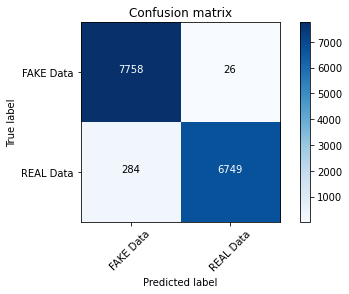

In [52]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier()

linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

<a id="13"></a>
<font size="+2" color="blue"><b>Hashing Vectorizer</b> </font><br>

accuracy:   0.938
Confusion matrix, without normalization


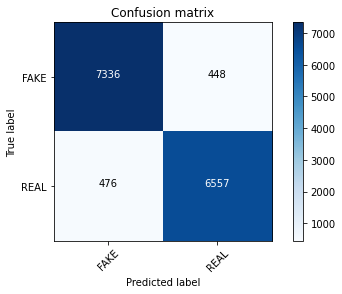

In [53]:
from sklearn.feature_extraction.text import HashingVectorizer


# create the transform
hashVec = HashingVectorizer(n_features=1000, alternate_sign=False)

# encode document
X = hashVec.fit_transform(corpus.values)

## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf_hash = MultinomialNB()
clf_hash.fit(X_train, y_train)
pred_hash = clf_hash.predict(X_test)
score_hash = metrics.accuracy_score(y_test, pred_hash)
print("accuracy:   %0.3f" % score_hash)
cm = metrics.confusion_matrix(y_test, pred_hash)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<a id="14"></a>
<font size="+2" color="blue"><b>Comparison of various BOW methods </b> </font><br>

In [54]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["S No.", "Vectorizer", "Accuracy"]

x.add_row(["1","CountVectorizer", 0.956])
x.add_row(["2","PassiveAggressiveClassifier - CountVectorizer", 0.994])
x.add_row(["3","TfidfVectorizer", 0.946])
x.add_row(["4","PassiveAggressiveClassifier - TfidfVectorizer", 0.982])
x.add_row(["5","HashingVectorizer", 0.94])

print(x)

+-------+-----------------------------------------------+----------+
| S No. |                   Vectorizer                  | Accuracy |
+-------+-----------------------------------------------+----------+
|   1   |                CountVectorizer                |  0.956   |
|   2   | PassiveAggressiveClassifier - CountVectorizer |  0.994   |
|   3   |                TfidfVectorizer                |  0.946   |
|   4   | PassiveAggressiveClassifier - TfidfVectorizer |  0.982   |
|   5   |               HashingVectorizer               |   0.94   |
+-------+-----------------------------------------------+----------+


<a id="15"></a>
<font size="+2" color="blue"><b>LSTM</b> </font><br>

In [55]:
### Vocabulary size
voc_size=5000

onehot_repr=[one_hot(words,voc_size)for words in corpus] 
print(onehot_repr[0])
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[0])
len(embedded_docs),y.shape

[3354, 1250, 3539, 239, 3820, 856, 4263, 4231, 618, 2576, 3539, 3947, 360, 3132, 4025, 2929, 4866, 1377, 856, 120, 297, 3820, 3539, 1653, 2451, 1912, 4032, 1377, 4720, 4731, 3761, 3894, 856, 4268, 2549, 4668, 4812, 181, 3704, 4767, 404, 2576, 2576, 4937, 529, 856, 2821, 901, 501, 3890, 4667, 4410, 3947, 3345, 3745, 2046, 2715, 4668, 162, 2624, 3539, 4907, 1948, 856, 3567, 2094, 4668, 1561, 1584, 4047, 4754, 66, 2969, 1912, 3093, 347, 944, 2576, 4045, 545, 806, 4720, 1093, 3539, 3394, 4668, 3393, 4754, 567, 742, 3192, 1912, 141, 856, 1561, 4767, 2576, 856, 1324, 3612, 1912, 5, 555, 1912, 2002, 1952, 3265, 3645, 2076, 4188, 1310, 3645, 3539, 4128, 4769, 3243, 2354, 1934, 2576, 4047, 4410, 567, 3165, 1912, 3720, 4844, 3820, 360, 1998, 179, 1239, 181, 760, 4410, 702, 856, 812, 4767, 4923, 2576, 1472, 1584, 4091, 1669, 2281, 702, 2924, 3807, 1377, 2030, 4668, 1584, 4668, 1179, 1738, 186, 693, 4136, 2288, 2248, 4306, 4700, 181, 2026, 1104, 4464, 1239, 704, 901, 3523, 3625, 4192, 1912, 675, 1

(44898, (44898,))

In [56]:
## Creating model
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

### Finally Training
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
471/471 [==============================] - 3s 7ms/step - loss: 1.4736e-05 - accuracy: 1.0000 - val_loss: 0.5298 - val_accuracy: 0.9416
Epoch 2/10
471/471 [==============================] - 3s 7ms/step - loss: 9.4483e-06 - accuracy: 1.0000 - val_loss: 0.5466 - val_accuracy: 0.9418
Epoch 3/10
471/471 [==============================] - 3s 7ms/step - loss: 6.4499e-06 - accuracy: 1.0000 - val_loss: 0.5613 - val_accuracy: 0.9420
Epoch 4/10
471/471 [==============================] - 3s 7ms/step - loss: 4.5581e-06 - accuracy: 1.0000 - val_loss: 0.5746 - val_accuracy: 0.9418
Epoch 5/10
471/471 [==============================] - 3s 7ms/step - loss: 3.2851e-06 - accuracy: 1.0000 - val_loss: 0.5892 - val_accuracy: 0.9416
Epoch 6/10
471/471 [==============================] - 4s 8ms/step - loss: 2.3907e-06 - accuracy: 1.0000 - val_loss: 0.6046 - val_accuracy: 0.9416
Epoch 7/10
471/471 [==============================] - 5s 11ms/step - loss: 1.7617e-06 - accuracy: 1.0000 - val_loss: 0.6202 

In [60]:
## Creating model - Bidirectional, no dropout
embedding_vector_features=40
model2 = Sequential()
model2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model2.add(Bidirectional(LSTM(100)))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
print(len(embedded_docs),y.shape)
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Training
history2 = model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

44898 (44898,)
Epoch 1/10
471/471 [==============================] - 8s 18ms/step - loss: 0.1656 - accuracy: 0.9371 - val_loss: 0.1765 - val_accuracy: 0.9328
Epoch 2/10
471/471 [==============================] - 5s 10ms/step - loss: 0.1035 - accuracy: 0.9631 - val_loss: 0.1830 - val_accuracy: 0.9333
Epoch 3/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0737 - accuracy: 0.9733 - val_loss: 0.1884 - val_accuracy: 0.9359
Epoch 4/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0545 - accuracy: 0.9811 - val_loss: 0.1957 - val_accuracy: 0.9369
Epoch 5/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0396 - accuracy: 0.9868 - val_loss: 0.2915 - val_accuracy: 0.9318
Epoch 6/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0287 - accuracy: 0.9908 - val_loss: 0.2625 - val_accuracy: 0.9366
Epoch 7/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0211 - accuracy: 0.9935 - val_loss: 0.2604 - val_a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [64]:
## Creating model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 40)            200000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              112800    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
print(len(embedded_docs),y.shape)
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Training
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)


44898 (44898,)
Epoch 1/10
471/471 [==============================] - 5s 10ms/step - loss: 0.1040 - accuracy: 0.9628 - val_loss: 0.1732 - val_accuracy: 0.9323
Epoch 2/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0742 - accuracy: 0.9743 - val_loss: 0.2000 - val_accuracy: 0.9359
Epoch 3/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0542 - accuracy: 0.9822 - val_loss: 0.1999 - val_accuracy: 0.9335
Epoch 4/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0533 - accuracy: 0.9816 - val_loss: 0.2264 - val_accuracy: 0.9354
Epoch 5/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.2502 - val_accuracy: 0.9345
Epoch 6/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0247 - accuracy: 0.9924 - val_loss: 0.2734 - val_accuracy: 0.9351
Epoch 7/10
471/471 [==============================] - 5s 10ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.2954 - val_a

In [69]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["S No.", "Deep Learning", "Accuracy"]

x.add_row(["1","LSTM", 0.9433])
x.add_row(["2","BiDirectional LSTM", 0.9431])
x.add_row(["3","BiDirectional LSTM + Dropout", 0.9367])

print(x)

+-------+------------------------------+----------+
| S No. |        Deep Learning         | Accuracy |
+-------+------------------------------+----------+
|   1   |             LSTM             |  0.9433  |
|   2   |      BiDirectional LSTM      |  0.9431  |
|   3   | BiDirectional LSTM + Dropout |  0.9367  |
+-------+------------------------------+----------+
